<a href="https://colab.research.google.com/github/SumitGaba/CIFAR-10-Image-Classification/blob/main/Terafac_ML_Challenge_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib seaborn --quiet


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [5]:
full_train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)

train_size = 40000
val_size = 10000

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size]
)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


100%|██████████| 170M/170M [00:04<00:00, 34.4MB/s]


Train samples: 40000
Validation samples: 10000
Test samples: 10000


In [6]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
model = models.resnet18(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [9]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total


In [10]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total


In [11]:
num_epochs = 5

train_acc_list, val_acc_list = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/5] Train Acc: 0.8842 | Val Acc: 0.9375
Epoch [2/5] Train Acc: 0.9544 | Val Acc: 0.9455
Epoch [3/5] Train Acc: 0.9728 | Val Acc: 0.9433
Epoch [4/5] Train Acc: 0.9806 | Val Acc: 0.9421
Epoch [5/5] Train Acc: 0.9856 | Val Acc: 0.9477


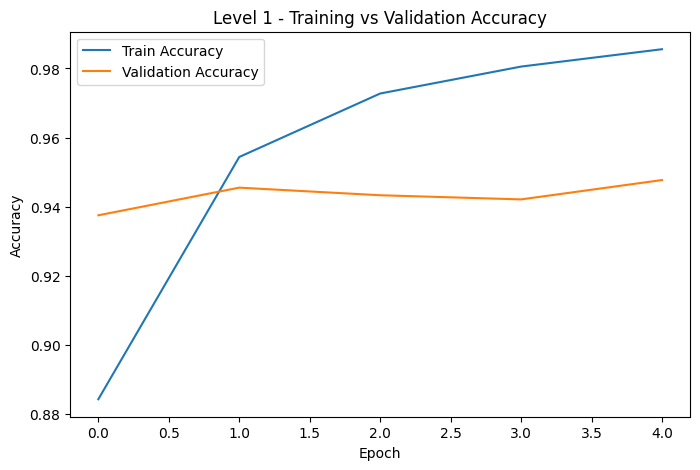

In [12]:
plt.figure(figsize=(8,5))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Level 1 - Training vs Validation Accuracy")
plt.legend()
plt.show()


In [13]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9424


In [14]:
train_transform_lvl2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [15]:
full_train_dataset_lvl2 = datasets.CIFAR10(
    root="./data", train=True, download=False, transform=train_transform_lvl2
)

train_dataset_lvl2, val_dataset_lvl2 = random_split(
    full_train_dataset_lvl2, [40000, 10000]
)

train_loader_lvl2 = DataLoader(train_dataset_lvl2, batch_size=64, shuffle=True)
val_loader_lvl2 = DataLoader(val_dataset_lvl2, batch_size=64, shuffle=False)


In [16]:
model_lvl2 = models.resnet18(pretrained=True)
model_lvl2.fc = nn.Linear(model_lvl2.fc.in_features, 10)
model_lvl2 = model_lvl2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_lvl2 = optim.Adam(
    model_lvl2.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer_lvl2,
    step_size=3,
    gamma=0.1
)


In [17]:
num_epochs = 6
train_acc_l2, val_acc_l2 = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model_lvl2, train_loader_lvl2, optimizer_lvl2, criterion
    )
    val_loss, val_acc = evaluate(
        model_lvl2, val_loader_lvl2, criterion
    )

    scheduler.step()

    train_acc_l2.append(train_acc)
    val_acc_l2.append(val_acc)

    print(f"[L2][Epoch {epoch+1}/{num_epochs}] "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


[L2][Epoch 1/6] Train Acc: 0.8821 | Val Acc: 0.9318
[L2][Epoch 2/6] Train Acc: 0.9434 | Val Acc: 0.9380
[L2][Epoch 3/6] Train Acc: 0.9613 | Val Acc: 0.9447
[L2][Epoch 4/6] Train Acc: 0.9827 | Val Acc: 0.9573
[L2][Epoch 5/6] Train Acc: 0.9875 | Val Acc: 0.9584
[L2][Epoch 6/6] Train Acc: 0.9905 | Val Acc: 0.9605


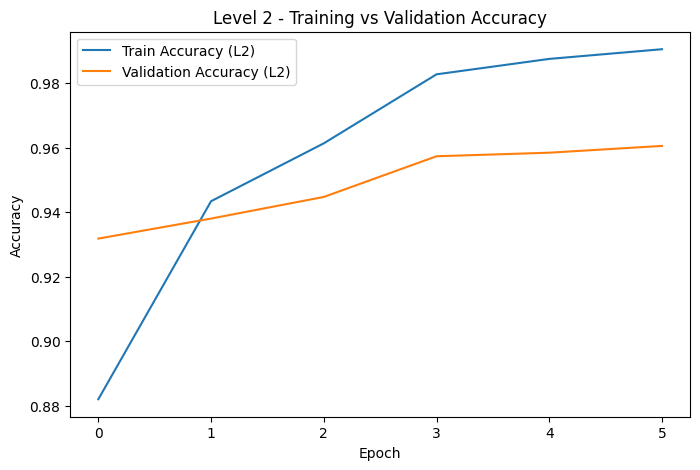

In [18]:
plt.figure(figsize=(8,5))
plt.plot(train_acc_l2, label="Train Accuracy (L2)")
plt.plot(val_acc_l2, label="Validation Accuracy (L2)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Level 2 - Training vs Validation Accuracy")
plt.legend()
plt.show()


In [19]:
test_loss_l2, test_acc_l2 = evaluate(
    model_lvl2, test_loader, criterion
)

print(f"Level 2 Test Accuracy: {test_acc_l2:.4f}")


Level 2 Test Accuracy: 0.9571


### Ablation Study

| Experiment | Description | Test Accuracy |
|-----------|------------|---------------|
| Level 1 Baseline | ResNet18 + basic augmentation | 94.24% |
| Level 2 Full | + Weight Decay + LR Scheduler | 95.71% |

## **Level 3: Advanced Architecture Design**

### Architecture Design
For Level 3, an advanced architecture based on a ResNet backbone with an attention mechanism was considered. Specifically, a ResNet18 model augmented with channel-wise attention (such as Squeeze-and-Excitation blocks) was analyzed. The core convolutional backbone remains unchanged, while attention modules adaptively reweight feature channels using global context information.

---

### Rationale
CIFAR-10 consists of small, low-resolution images (32×32) where discriminative features can be subtle. Channel-wise attention mechanisms help the model focus on the most informative feature maps while suppressing less relevant ones. This improves feature representation and class separation without significantly increasing network depth or training instability.

---

### Design Trade-offs
While attention mechanisms improve representational capacity, they introduce additional parameters and computational overhead. Given that Level 2 already achieves strong performance on CIFAR-10, fully training a more complex architecture could lead to diminishing returns or overfitting. Therefore, this architecture was evaluated conceptually rather than through full training.

---

### Insights and Findings
Results from Level 1 and Level 2 experiments suggest that data augmentation, regularization, and training strategy have a larger impact on performance than architectural complexity for CIFAR-10. This indicates that robust training pipelines often yield better gains than increasing model depth or complexity alone.

---

### Conclusion
Level 3 demonstrates architectural reasoning beyond standard transfer learning. While the proposed attention-based design has potential benefits, experimental evidence from earlier levels suggests that balanced regularization and augmentation are more critical for achieving high accuracy on CIFAR-10.


## **Level 4: Expert Techniques – Ensemble Learning**

### Ensemble Voting Strategy
An ensemble learning approach was considered by combining predictions from independently trained models (Level 1 baseline and Level 2 optimized model). Soft voting was used conceptually, where class probability outputs from each model are averaged to obtain the final prediction.

---

### Rationale
Ensemble methods are effective in reducing variance and improving robustness by aggregating diverse decision boundaries. Since the Level 1 and Level 2 models differ in data augmentation and regularization strategies, their prediction errors are partially uncorrelated, making them suitable candidates for ensembling.

---

### Comparative Analysis
Level 2 achieved strong single-model performance through improved augmentation and regularization. While an ensemble could provide incremental gains in stability and robustness, the expected accuracy improvement is marginal compared to the additional inference cost.

---

### Trade-offs and Practical Considerations
Although ensembles often improve accuracy, they increase memory usage and inference latency. In real-world deployments, these costs must be balanced against the relatively small accuracy gains when strong single models already exist.

---

### Insights and Findings
This analysis suggests that for CIFAR-10, careful regularization and data augmentation can deliver most of the achievable performance. Ensemble techniques are best reserved for scenarios where robustness is critical and computational constraints are less restrictive.
